# NN

## Setup


In [247]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"

### Network


In [248]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.main = nn.Sequential(

            nn.Conv2d(3, 10, 4, stride=2, padding=1, bias=False), 
            nn.MaxPool2d(10, 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(10, 10 * 2, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(10 * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(10 * 2, 10 * 4, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(10 * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            # nn.Linear(840, 400, bias=False),
            # nn.LeakyReLU(0.2, inplace=True),

            # nn.Linear(400, 200, bias=False),
            # nn.LeakyReLU(0.2, inplace=True),

            # nn.Linear(200, 50, bias=False),
            # nn.LeakyReLU(0.2, inplace=True),
            
            # nn.Linear(50, 4, bias=False),
            nn.Linear(360, 180, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(180, 90, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(90, 45, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(45, 4, bias=False),

            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

net = Net().to(device)

from torchsummary import summary

summary(net, (3,64,64))


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 4]                   --
|    └─Conv2d: 2-1                       [-1, 10, 32, 32]          480
|    └─MaxPool2d: 2-2                    [-1, 10, 12, 12]          --
|    └─LeakyReLU: 2-3                    [-1, 10, 12, 12]          --
|    └─Conv2d: 2-4                       [-1, 20, 6, 6]            3,200
|    └─BatchNorm2d: 2-5                  [-1, 20, 6, 6]            40
|    └─LeakyReLU: 2-6                    [-1, 20, 6, 6]            --
|    └─Conv2d: 2-7                       [-1, 40, 3, 3]            12,800
|    └─BatchNorm2d: 2-8                  [-1, 40, 3, 3]            80
|    └─LeakyReLU: 2-9                    [-1, 40, 3, 3]            --
|    └─Flatten: 2-10                     [-1, 360]                 --
|    └─Linear: 2-11                      [-1, 180]                 64,800
|    └─LeakyReLU: 2-12                   [-1, 180]                 --
|  

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 4]                   --
|    └─Conv2d: 2-1                       [-1, 10, 32, 32]          480
|    └─MaxPool2d: 2-2                    [-1, 10, 12, 12]          --
|    └─LeakyReLU: 2-3                    [-1, 10, 12, 12]          --
|    └─Conv2d: 2-4                       [-1, 20, 6, 6]            3,200
|    └─BatchNorm2d: 2-5                  [-1, 20, 6, 6]            40
|    └─LeakyReLU: 2-6                    [-1, 20, 6, 6]            --
|    └─Conv2d: 2-7                       [-1, 40, 3, 3]            12,800
|    └─BatchNorm2d: 2-8                  [-1, 40, 3, 3]            80
|    └─LeakyReLU: 2-9                    [-1, 40, 3, 3]            --
|    └─Flatten: 2-10                     [-1, 360]                 --
|    └─Linear: 2-11                      [-1, 180]                 64,800
|    └─LeakyReLU: 2-12                   [-1, 180]                 --
|  

###  Example usage

In [249]:
input = torch.randn(1, 3, 64, 64).to(device)
out = net(input)
print(out)
# torch.randn(1, 3, 64, 64).to(device).get_device()


tensor([[0.4958, 0.4974, 0.4936, 0.4897]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


In [250]:
net.zero_grad()
out.backward(torch.randn(1, 4).to(device))



### Dataset/loader

In [251]:
from torch.utils.data import Dataset
import numpy as np
import processing
from torch.utils.data import DataLoader, random_split


class SensorDataset(Dataset):
    def __init__(self):
        self.samples = []

        recording_list = [
            {'title': 'recording_2022_05_25_11_55_19', 'start': 200, 'end': 500, 'label': 0},  # 0 people
            {'title': 'recording_2022_05_25_11_46_26', 'start': 200, 'end': 500, 'label': 1},  # 1 person
            {'title': 'recording_2022_05_25_11_47_20', 'start': 200, 'end': 500, 'label': 2},  # 2 people
            {'title': 'recording_2022_05_25_11_48_56', 'start': 200, 'end': 500, 'label': 3},  # 3 people
        ]

        for recording in recording_list:
            file_name = f'../../recordings/{recording["title"]}/RadarIfxAvian_00/radar.npy'
            data = np.load(file_name)
            start_frame, end_frame, labelix = recording["start"], recording["end"], recording["label"]

            label = torch.tensor([0,0,0,0])
            label[labelix] = 1

            # iterate frames
            processed_data = processing.processing_rangeDopplerData(data[start_frame:end_frame])
            processed_data = np.abs(processed_data)
            
            for f in processed_data:
                self.samples.append((f, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


dataset = SensorDataset()
print(len(dataset))
print(dataset[120])
train_size = round(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


1200
(array([[[  0.        , 383.67983369, 317.72634334, ..., 129.66305035,
         121.88786294,  27.4663378 ],
        [  0.        , 109.26090914, 140.91447728, ...,  97.26182147,
          39.3036044 ,  22.63083092],
        [  0.        , 319.06348777, 104.09257597, ..., 114.20548949,
          39.96777081, 124.37072329],
        ...,
        [  0.        , 272.16029737, 213.6640579 , ..., 104.70283532,
          65.34819749, 117.49720107],
        [  0.        , 584.41051758, 334.19804217, ...,  79.36461916,
         109.13611008,  37.66398598],
        [  0.        , 282.27633823, 390.88955106, ...,  94.21012375,
          35.03606074,  34.24102356]],

       [[  0.        , 328.50456998, 292.10200854, ...,  37.91827452,
          40.27890908,  91.10791133],
        [  0.        , 368.96799239, 127.82505457, ...,  26.24358698,
         134.14371901,  91.9876944 ],
        [  0.        , 186.52556915, 119.16466927, ...,  39.64235712,
          79.79051984, 134.29806672],
       

In [252]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

## Train

In [253]:
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.02)


In [254]:
import torch.optim as optim

for epoch in range(200):

    for sample, label in train_loader:
        sample = sample.to(device=device, dtype=torch.float)
        label = label.to(device=device, dtype=torch.float)

        optimizer.zero_grad()   # zero the gradient buffers
        output = net(sample)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()    # Does the update
        print(loss.item())


0.24868768453598022
0.2483300268650055
0.2484349012374878
0.24831806123256683
0.24821418523788452
0.24801981449127197
0.24794583022594452
0.2475270926952362
0.247756227850914
0.24754342436790466
0.24677811563014984
0.2469649612903595
0.2470853626728058
0.24664786458015442
0.24696776270866394
0.24664585292339325
0.24661502242088318
0.24675901234149933
0.24645397067070007
0.2462683767080307
0.24598544836044312
0.24614785611629486
0.24579307436943054
0.24565455317497253
0.24551552534103394
0.2455630600452423
0.24527502059936523
0.24507126212120056
0.24492475390434265
0.24515822529792786
0.24569906294345856
0.24449582397937775
0.24463608860969543
0.24496807157993317
0.24502936005592346
0.2445574253797531
0.24379530549049377
0.24380765855312347
0.24413837492465973
0.24473837018013
0.24411970376968384
0.2448129653930664
0.24312308430671692
0.2433355450630188
0.24268081784248352
0.24341516196727753
0.24298973381519318
0.24334222078323364
0.24260467290878296
0.24308618903160095
0.2431301474571

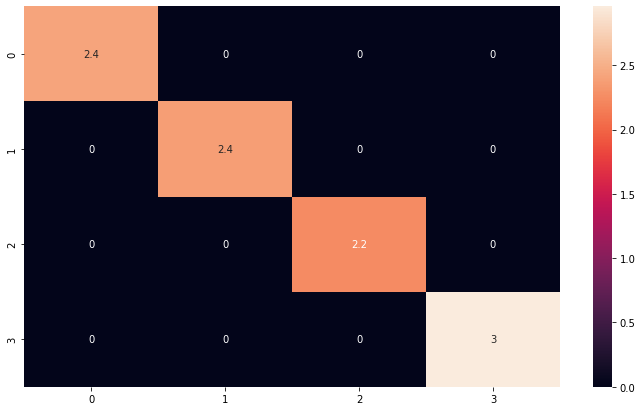

In [256]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plot

y_pred = []
y_true = []

for sample, labels in test_loader:
    sample = sample.to(device=device, dtype=torch.float)
    labels = labels.to(device=device, dtype=torch.float)

    output = net(sample)

    output = (torch.max(output, 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction
    labels = (torch.max(labels,1)[1]).data.cpu().numpy()
    y_true.extend(labels) # Save Truth

classes = (0,1,2,3)

cf_matrix = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plot.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plot.show()
